In [1]:
!pip install pyswarms

     |████████████████████████████████| 112kB 2.9MB/s 


In [30]:
import pyswarms as ps

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from matplotlib.animation import FuncAnimation
from IPython import display

import time

from scipy.integrate import odeint,simps

In [4]:
Cva=0.0824 #kmol/m3
Cbv=1.5324 #kmol/m3
Ccv=0 #kmol/m3
q=0.0720 #m3/min
qc=0.6307  #m3/min
ro=974.19 #kg/m3
roc=998 #kg/m3
Cp=3.7187 #kJ/(kg*K)
Cpc=4.182#kJ/(kg*K)
V=2.407 #m3
Vc=2 #m3
A=8.695 #m2
alpha=13.8 #kJ/(min*m2*K)
Tv=299.05 #K
Tvc=288.15 #K
g=10183 #K
DrH=-5.46e6 #kJ/kmol
kinf=2.8233e11 #min-1

#Inicialmente....
Ca=Cva
T=Tv
Tc=Tvc
#Leitura dos dados
data=pd.read_csv('Dados_gerados_case_geral_t_2_v2', sep='\t', encoding='utf-8',header=None)

data.columns=['Tvc_','T_','Tvc_t-1','T_t-1','Tvc_t-2','T_t-2']

#data=data.drop(['qc_','Tv_','Tvc_','q_'],axis=1)

data=data.dropna()


2021-05-31 18:22:32,597 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


In [5]:

#---------------------------------------------------------------------------------------


#Definição de targets

#target_tc=data.pop('Tc_')
#target_ca=data.pop('Ca_')
target=data.pop('T_')
_=data.pop('Tvc_')
#Padronização dos dados
scaler=StandardScaler()

entrada=scaler.fit_transform(data)


X_train=entrada[1000:32000,:]
y_train=target[1000:32000]

X_test=entrada[32000:,:]
y_test=target[32000:]


"""Quando treinar RNN"""

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [7]:
model = tf.keras.models.load_model('Treino_GRU_v2.h5')

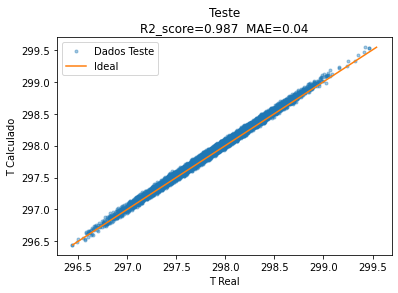

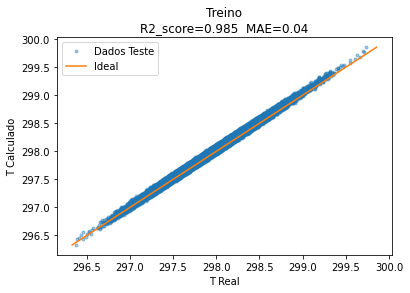

In [8]:

calc=model.predict(X_test).reshape(-1,1)

plt.title( 'Teste\nR2_score='+'%.3f'%r2_score(y_test,calc)+'  MAE='+'%.2f'% mean_absolute_error(y_test,calc))
plt.plot(y_test,calc,'.',label='Dados Teste',alpha=0.4)
plt.plot([min(calc),max(calc)],[min(calc),max(calc)],'-',label='Ideal')
plt.xlabel('T Real')
plt.ylabel('T Calculado')
plt.legend()
plt.show()


a=model.predict(X_train).reshape(-1,1)
plt.title( 'Treino\nR2_score='+'%.3f'%r2_score(y_train,a)+'  MAE='+'%.2f'% mean_absolute_error(y_train,a))
plt.plot(y_train,a,'.',label='Dados Teste',alpha=0.4)
plt.plot([min(a),max(a)],[min(a),max(a)],'-',label='Ideal')
plt.xlabel('T Real')
plt.ylabel('T Calculado')
plt.legend()
plt.show()

In [ ]:
#model = tf.keras.models.load_model('Treino_GRU_v2.h5')

In [9]:



def J(u):   
    """
    u=Tvc[t-1,t,t+1]
    model = rede neural treinada
    h_pred = horizonte de predição
    h_contr = horizonte de controle
    SP = Set-point
    """
    global model,h_pred,SP,Tvc_t_1,T_t_1,Tvc_t_2,T_t_2,T_t_1_,T_,Tvc_t_2_,T_t_2_,T_t_1_
    #Parâmetro referente ao controlador (verificar artigos)
    wT=1000
    lambda_q=0.01

#    start_time = time.time()
#    Loop para cálculo do horizonte de predição
    
    #Informação do Tvc para ser utilizado no df 'd_Tvc'
    Tvc_t_2_=Tvc_t_2
    
    T_t_2_=T_t_2
    T_t_1_=T_t_1
    
    T_=[]
    
    for i in range(h_pred):
        
        if i<3:
          
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[i],
                                                                                   T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[i]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
        else:
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[3],
                                                                               T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[3]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
#    print("--- %s seconds ---" % (time.time() - start_time))
   
    #Array com os set points no decorrer da predição
    y_ref=[SP]*h_pred
    
    #Horizonte de controle (3)
    d_Tvc=[]
    d_Tvc.append((u[0]-Tvc_t_2_)**2)
    d_Tvc.append((u[1]-u[0])**2)
    d_Tvc.append((u[2]-u[1])**2)
    d_Tvc.append((u[3]-u[2])**2)
    
       
    #função objetivo
    obj=wT*sum((pd.Series(y_ref)-pd.Series(T_))**2)+lambda_q*sum(pd.Series(d_Tvc))
    
    return obj

#EDO do sistema (cstr)
def plant(z,t):
    global q,Cva,V,kinf,g,Tv,alpha,A,ro,Cp,DrH,qc,Tvc,Vc,roc,Cpc
    Ca  = z[0]
    T   = z[1]
    Tc  = z[2]
    
    dCadt=(q*(Cva-Ca)/V)-(kinf*np.exp(-g/T)*Ca)
    dTdt=((Tv-T)*q/V) -(alpha*A*(T-Tc)/(V*ro*Cp))+(kinf*np.exp(-g/T)*Ca*(-DrH)/(ro*Cp))
    dTcdt=(qc*(Tvc-Tc)/Vc)+(alpha*A*(T-Tc)/(Vc*roc*Cpc))
    dzdt = [dCadt,dTdt,dTcdt]
    
    return dzdt


In [10]:

#FO
qc_t_1=0.6307
Tv_t_1=299.05
Tvc_t_1=288.15
q_t_1=0.072
T_t_1=296.7227
qc_t_2=0.6307
Tv_t_2=299.05
Tvc_t_2=288.15
q_t_2=0.072
T_t_2=296.7227

#Condições iniciais da EDO (partindo do estado estacionário)
Ca=0.0814416
T=296.7227
Tc=288.5237
Tvc=288.15

Tv=299.05 #K
#---------------------
#Entradas - Horizonte de predição e Set-point
h_pred=6
SP=298

z_=[]
z0 = [Ca,T,Tc]
Tvc_=[]
sp_=[]

u=[288.15,288.15,288.15,288.15]
					
def min_f(particles):
        return [J(particle) for particle in particles]
    
    
constraints = (np.array([275,275,275,275]),
               np.array([310,310,310,310]))

In [11]:
start_time = time.time()
final_step=180
for i in range(final_step):
     
    if i==15:
        SP=299
    elif i==30:
        SP=297
    elif i==60:
        SP=298
    elif i==75:
        SP=300
    elif i==95:
        SP=297
    elif i==125:
        SP=298
    elif i==150:
        SP=301
    elif i==180:
        SP=298
    
    options={'c1':2,'c2':2,'w':0.5}
    optimizer=ps.single.GlobalBestPSO(n_particles=15,dimensions=4,options=options,bounds=constraints)
    popt=optimizer.optimize(min_f,iters=5)
    
    
    Tvc=popt[1][0]
    Tvc_.append(Tvc)
    #Intervalos de tempo para a integração
    t = np.linspace(0,1,2)
    
    z_.append(np.ndarray.tolist(odeint(plant,z0,t)[1]))
    
    z0=z_[-1]
    
#    Atualização do valor para a próxima iteração
    Tvc_t_2=Tvc_t_1
    Tvc_t_1=Tvc

    
    T_t_2=T_t_1
    T_t_1=z0[1]
    
    u=popt[1]
    
    print(z_)
    print('\n')
    print(T_)
    
    print('\n %.1f %%'%(i*100/final_step))
    print(70*'=')
    
    sp_.append(SP)
    
print("--- %s seconds ---" % (time.time() - start_time))

2021-05-31 18:23:56,700 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.88e+3
2021-05-31 18:23:58,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2879.1463008420355, best pos: [308.53533456 309.92412764 306.45459058 306.61371269]
2021-05-31 18:23:58,928 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337]]


[296.7416076660156, 296.81060791015625, 296.9906921386719, 297.2331237792969, 297.5042419433594, 297.79205322265625]

 0.0 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.21e+3
2021-05-31 18:24:01,075 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2211.215247691315, best pos: [309.62557858 309.81000567 303.45054188 290.79478379]
2021-05-31 18:24:01,094 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773]]


[296.8244323730469, 296.8475341796875, 296.9505615234375, 297.1309509277344, 297.35723876953125, 297.6128234863281]

 0.6 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.54e+3
2021-05-31 18:24:03,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1537.2213362947703, best pos: [308.90118969 293.30011295 300.98083049 288.06731664]
2021-05-31 18:24:03,342 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605]]


[296.94366455078125, 297.0039367675781, 297.09478759765625, 297.2349853515625, 297.414794921875, 297.6204833984375]

 1.1 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=842
2021-05-31 18:24:05,540 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 842.0059472196922, best pos: [305.46880253 304.52095611 288.31620204 280.94641838]
2021-05-31 18:24:05,559 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215]]


[297.2108459472656, 297.4599914550781, 297.69976806640625, 297.8586730957031, 297.94122314453125, 297.9701843261719]

 1.7 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=430
2021-05-31 18:24:07,744 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 429.6584553137526, best pos: [309.38603671 291.83696984 284.027769   280.87667018]
2021-05-31 18:24:07,761 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606]]


[297.43487548828125, 297.7169189453125, 297.9354248046875, 298.16241455078125, 298.42230224609375, 298.7044677734375]

 2.2 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=202
2021-05-31 18:24:09,973 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 201.9545305089405, best pos: [305.78971552 286.45195598 278.47695751 283.35602101]
2021-05-31 18:24:09,994 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373]]


[297.487060546875, 297.5304260253906, 297.5090026855469, 297.45745849609375, 297.39093017578125, 297.31414794921875]

 2.8 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=92.9
2021-05-31 18:24:12,177 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 92.85637089790488, best pos: [290.09567986 280.50521953 288.75859994 278.77809745]
2021-05-31 18:24:12,191 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164]]


[297.74359130859375, 297.9915771484375, 298.1897888183594, 298.33111572265625, 298.4395751953125, 298.5247497558594]

 3.3 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=34.3
2021-05-31 18:24:14,386 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34.32670416140059, best pos: [283.42542669 284.58738935 281.82178971 285.2730692 ]
2021-05-31 18:24:14,400 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314]]


[297.91748046875, 298.09136962890625, 298.1847229003906, 298.27972412109375, 298.4002380371094, 298.5383605957031]

 3.9 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=16.3
2021-05-31 18:24:16,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 16.296175310978224, best pos: [292.33641245 282.04965173 280.43608086 282.74557186]
2021-05-31 18:24:16,623 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399]]


[297.896484375, 298.0004577636719, 298.0586242675781, 298.08349609375, 298.09039306640625, 298.0846252441406]

 4.4 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=17.3
2021-05-31 18:24:18,781 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 17.277236676423588, best pos: [292.45383861 280.99042847 292.11281171 281.50909567]
2021-05-31 18:24:18,797 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091]]


[297.89605712890625, 297.9183349609375, 297.9688720703125, 298.01824951171875, 298.0511169433594, 298.0722961425781]

 5.0 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=7.48
2021-05-31 18:24:21,025 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.484898109040969, best pos: [287.26802634 282.6335543  284.07240962 285.50894747]
2021-05-31 18:24:21,039 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943]]


[297.9080810546875, 297.9966125488281, 298.0928039550781, 298.1565856933594, 298.1939697265625, 298.21270751953125]

 5.6 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=9.37
2021-05-31 18:24:23,236 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.369586644045407, best pos: [289.00458484 281.55606782 284.86989848 288.22549532]
2021-05-31 18:24:23,250 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876]]


[297.9600524902344, 297.9830322265625, 298.0752868652344, 298.1784362792969, 298.26031494140625, 298.3270568847656]

 6.1 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=7.5
2021-05-31 18:24:25,403 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.497895454635908, best pos: [290.15909202 291.80783273 276.51166438 285.85370865]
2021-05-31 18:24:25,423 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154]]


[297.9407958984375, 297.9767150878906, 298.00750732421875, 298.0581970214844, 298.13165283203125, 298.2208557128906]

 6.7 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=11
2021-05-31 18:24:27,724 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11.04039016491815, best pos: [288.00354886 294.32845984 282.93394933 282.48388652]
2021-05-31 18:24:27,740 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862]]


[297.9217834472656, 297.9731750488281, 298.01007080078125, 298.0963439941406, 298.2450256347656, 298.43701171875]

 7.2 %


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=11
2021-05-31 18:24:29,872 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11.021240331226206, best pos: [290.65609658 290.90210175 284.97123251 281.32301716]
2021-05-31 18:24:29,891 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154]]


[297.9081115722656, 297.9606628417969, 298.0274658203125, 298.075836

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.24e+3
2021-05-31 18:24:32,110 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2236.7493967231258, best pos: [309.45704276 308.24952077 296.47049305 301.86147477]
2021-05-31 18:24:32,133 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066]]


[297.8

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.05e+3
2021-05-31 18:24:34,426 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2054.7650717121082, best pos: [308.72772565 303.05346995 291.14958909 302.62763988]
2021-05-31 18:24:34,448 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.09e+3
2021-05-31 18:24:36,724 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1090.3264597946088, best pos: [308.73762785 309.50841224 298.81718939 281.39066779]
2021-05-31 18:24:36,749 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=737
2021-05-31 18:24:38,947 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 736.6441728119969, best pos: [307.1995276  303.48444635 283.45705479 283.12783147]
2021-05-31 18:24:38,961 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=398
2021-05-31 18:24:41,125 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 398.04397690887345, best pos: [308.53404092 308.16107448 277.86862694 278.71519158]
2021-05-31 18:24:41,146 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=212
2021-05-31 18:24:43,299 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 212.0576590771787, best pos: [302.36089834 295.92105143 276.32399802 282.63250175]
2021-05-31 18:24:43,319 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=77.6
2021-05-31 18:24:45,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 77.59300169899743, best pos: [305.18442255 279.84647856 275.27479368 281.65208528]
2021-05-31 18:24:45,503 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=41.6
2021-05-31 18:24:47,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 41.60468519056493, best pos: [290.31088576 282.35595584 279.69704571 286.1459741 ]
2021-05-31 18:24:47,621 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=18.4
2021-05-31 18:24:49,790 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.443030554033864, best pos: [283.90071376 286.45843372 277.27345044 284.84283532]
2021-05-31 18:24:49,805 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=13.4
2021-05-31 18:24:51,935 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 13.42917560183562, best pos: [299.09725872 279.78500513 278.43952576 283.67745605]
2021-05-31 18:24:51,955 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=12.4
2021-05-31 18:24:54,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 12.411298637651118, best pos: [298.63824374 277.9177225  287.47401599 284.37910446]
2021-05-31 18:24:54,078 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=6.27
2021-05-31 18:24:56,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.272899013061745, best pos: [287.40790515 279.16469691 290.99865346 284.58618666]
2021-05-31 18:24:56,247 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=5.82
2021-05-31 18:24:58,390 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.816381597553563, best pos: [288.21209808 281.80050295 283.58816948 285.2041087 ]
2021-05-31 18:24:58,405 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=14.3
2021-05-31 18:25:00,568 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.297636672895653, best pos: [300.91096958 281.84261241 278.57477037 283.344387  ]
2021-05-31 18:25:00,591 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=12.8
2021-05-31 18:25:02,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 12.76684908539421, best pos: [291.2727816  285.06348734 285.25202332 285.20260462]
2021-05-31 18:25:02,752 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.88e+4
2021-05-31 18:25:04,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18800.601368047224, best pos: [278.29477669 276.91759308 280.83324391 286.67760062]
2021-05-31 18:25:04,935 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.77e+4
2021-05-31 18:25:07,165 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 17669.938841250285, best pos: [275.13923623 290.34335484 282.61174998 283.40479379]
2021-05-31 18:25:07,182 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.15e+4
2021-05-31 18:25:09,340 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11470.287898596835, best pos: [276.92645592 276.29659447 284.81200916 277.94440741]
2021-05-31 18:25:09,360 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=9.15e+3
2021-05-31 18:25:11,550 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9146.808379832872, best pos: [281.0138756  279.18577346 282.19942707 275.26674931]
2021-05-31 18:25:11,580 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=6.78e+3
2021-05-31 18:25:13,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6779.287877231728, best pos: [275.06707127 283.78252153 277.9894442  280.67150748]
2021-05-31 18:25:13,717 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=5.15e+3
2021-05-31 18:25:15,842 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5153.644384292167, best pos: [281.33683349 280.97882518 275.95527923 276.84697169]
2021-05-31 18:25:15,862 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.41e+3
2021-05-31 18:25:18,011 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3411.553004707454, best pos: [277.04945843 283.77385356 278.11143563 280.21371307]
2021-05-31 18:25:18,026 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.66e+3
2021-05-31 18:25:20,169 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2662.8111988156024, best pos: [275.93184542 276.98035003 296.75626127 282.06322639]
2021-05-31 18:25:20,189 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.48e+3
2021-05-31 18:25:22,302 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1481.8441863628927, best pos: [277.84970866 289.45613976 281.32901255 276.5563503 ]
2021-05-31 18:25:22,316 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=803
2021-05-31 18:25:24,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 802.9845033446218, best pos: [284.75881806 275.52829263 289.59325923 281.01521134]
2021-05-31 18:25:24,407 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=272
2021-05-31 18:25:26,564 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 272.34557709888105, best pos: [275.01820861 275.09729679 282.37267179 282.5808862 ]
2021-05-31 18:25:26,587 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=105
2021-05-31 18:25:28,722 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 105.47060839148331, best pos: [275.73847776 280.04452458 284.87187029 290.59152493]
2021-05-31 18:25:28,736 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=24
2021-05-31 18:25:30,840 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24.003152866798555, best pos: [283.189134   281.4311109  296.94570437 284.46455414]
2021-05-31 18:25:30,854 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=9.11
2021-05-31 18:25:32,963 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.10518800252671, best pos: [289.83713894 291.46462977 286.58993414 280.11731851]
2021-05-31 18:25:32,986 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.33
2021-05-31 18:25:35,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.3331279067229738, best pos: [296.86307977 285.11121283 283.61063589 283.63995402]
2021-05-31 18:25:35,169 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=8.8
2021-05-31 18:25:37,397 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.79624370570403, best pos: [289.88208292 286.74146784 279.84095886 287.83706358]
2021-05-31 18:25:37,410 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=18.8
2021-05-31 18:25:39,611 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.793174843835885, best pos: [280.12319795 288.10647196 294.00822162 281.88463274]
2021-05-31 18:25:39,631 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=15.7
2021-05-31 18:25:41,817 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 15.67978305298021, best pos: [300.02711121 280.83219284 276.02406711 282.72482299]
2021-05-31 18:25:41,856 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=15.4
2021-05-31 18:25:44,013 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 15.421595770962236, best pos: [301.72551591 282.20033855 276.02164305 286.20321406]
2021-05-31 18:25:44,037 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=16
2021-05-31 18:25:46,229 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 16.032911528341632, best pos: [275.2434915  284.71964733 289.58323734 284.81660296]
2021-05-31 18:25:46,242 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=5.25
2021-05-31 18:25:48,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.248281098506759, best pos: [281.17873647 283.91443546 282.04894753 286.93019903]
2021-05-31 18:25:48,373 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=13.8
2021-05-31 18:25:50,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 13.761668039769713, best pos: [299.99614024 283.4926548  283.55234344 279.81884792]
2021-05-31 18:25:50,620 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=12.9
2021-05-31 18:25:52,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 12.934719635928648, best pos: [298.03059112 281.8367292  280.67617553 280.15455204]
2021-05-31 18:25:52,798 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=4.57
2021-05-31 18:25:54,982 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.570494280661494, best pos: [288.92466248 278.61545226 278.89239864 284.15206795]
2021-05-31 18:25:54,995 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.88
2021-05-31 18:25:57,237 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.876119678072788, best pos: [276.56469891 285.54325733 284.7663517  283.75908804]
2021-05-31 18:25:57,264 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=0.755
2021-05-31 18:25:59,446 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7548586565231751, best pos: [285.29917027 282.23617287 284.93918741 282.99390861]
2021-05-31 18:25:59,460 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=4.92
2021-05-31 18:26:01,699 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.9211743933020555, best pos: [291.04170369 286.98412321 280.1014321  286.2696832 ]
2021-05-31 18:26:01,713 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.88
2021-05-31 18:26:03,902 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.876994358604248, best pos: [290.23285057 286.8267988  280.40440795 284.74102092]
2021-05-31 18:26:03,925 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=14.6
2021-05-31 18:26:06,142 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.573979847382564, best pos: [287.13699966 279.2446252  290.44016972 281.29173638]
2021-05-31 18:26:06,155 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=14.1
2021-05-31 18:26:08,376 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.108250138753093, best pos: [290.65589626 283.66055527 288.91634308 280.99075741]
2021-05-31 18:26:08,403 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.7e+3
2021-05-31 18:26:10,659 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1696.0075561434337, best pos: [309.71826686 308.77254944 306.67952401 281.29769094]
2021-05-31 18:26:10,672 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.55e+3
2021-05-31 18:26:12,824 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1552.432952402591, best pos: [306.08861307 301.24027573 305.24513725 291.69821415]
2021-05-31 18:26:12,853 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=818
2021-05-31 18:26:15,034 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 818.3523948667691, best pos: [307.21332111 301.93650974 293.61674835 280.03616554]
2021-05-31 18:26:15,047 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=461
2021-05-31 18:26:17,163 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 461.0495658598949, best pos: [305.94808166 308.56887429 275.83504312 279.43233821]
2021-05-31 18:26:17,176 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=217
2021-05-31 18:26:19,374 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 216.98865002662708, best pos: [309.66304503 289.04005221 276.74792223 282.59028956]
2021-05-31 18:26:19,387 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=104
2021-05-31 18:26:21,570 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 103.9440365224394, best pos: [295.17835133 288.0528284  281.15200968 277.88021265]
2021-05-31 18:26:21,585 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=36.4
2021-05-31 18:26:23,778 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36.3904001609125, best pos: [286.04269598 290.79172827 276.14864878 280.17656773]
2021-05-31 18:26:23,801 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=23.7
2021-05-31 18:26:25,978 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 23.704557971793548, best pos: [292.4475456  277.64768638 287.67722994 283.83349862]
2021-05-31 18:26:25,994 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=11
2021-05-31 18:26:28,261 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.96660073884242, best pos: [295.21171088 279.37428219 276.35287551 289.27922986]
2021-05-31 18:26:28,278 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=32.4
2021-05-31 18:26:30,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 32.39873309802602, best pos: [276.44681534 292.23383291 275.34282919 288.04486551]
2021-05-31 18:26:30,467 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=8.73
2021-05-31 18:26:32,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.732911985240342, best pos: [281.98231979 292.13876435 279.59987281 284.93314915]
2021-05-31 18:26:32,703 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=18.5
2021-05-31 18:26:34,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.51889397650769, best pos: [301.44123486 282.48247924 290.84563561 280.2139123 ]
2021-05-31 18:26:34,898 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=25.6
2021-05-31 18:26:37,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 25.565454550299453, best pos: [289.50084929 300.14766042 282.19908671 280.94756682]
2021-05-31 18:26:37,058 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=18.9
2021-05-31 18:26:39,161 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.903310247837773, best pos: [286.38373858 291.25055931 281.36967884 282.20387125]
2021-05-31 18:26:39,186 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=31.9
2021-05-31 18:26:41,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 31.945297762967275, best pos: [288.80825847 291.90262382 290.75286833 283.54632391]
2021-05-31 18:26:41,324 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.47e+4
2021-05-31 18:26:43,414 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14709.640992728624, best pos: [307.76317603 309.31063822 293.95214613 303.06434009]
2021-05-31 18:26:43,432 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.33e+4
2021-05-31 18:26:45,603 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 13337.842016119394, best pos: [309.70007615 299.88927304 305.97251579 303.65174554]
2021-05-31 18:26:45,619 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=9.46e+3
2021-05-31 18:26:47,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9458.598508483843, best pos: [307.48412787 307.06312872 309.52416222 304.752465  ]
2021-05-31 18:26:47,790 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=8e+3
2021-05-31 18:26:49,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8002.734919779034, best pos: [303.60286932 308.0857123  305.80174537 302.18283159]
2021-05-31 18:26:49,950 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=8.44e+3
2021-05-31 18:26:52,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8440.618922144688, best pos: [308.91173907 294.65147251 291.80560363 286.2302236 ]
2021-05-31 18:26:52,077 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=5.01e+3
2021-05-31 18:26:54,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5012.443550378041, best pos: [306.74691058 309.01568084 294.40940425 303.41333021]
2021-05-31 18:26:54,336 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.73e+3
2021-05-31 18:26:56,574 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3733.3865929175568, best pos: [305.89155115 302.61579887 301.9819778  299.85779272]
2021-05-31 18:26:56,589 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.67e+3
2021-05-31 18:26:58,794 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2670.7185362325245, best pos: [309.17303332 302.75899115 294.86577218 301.84977638]
2021-05-31 18:26:58,821 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.86e+3
2021-05-31 18:27:00,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1858.8810217712053, best pos: [309.94343013 305.42003008 279.28873377 301.11600944]
2021-05-31 18:27:01,010 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.02e+3
2021-05-31 18:27:03,122 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1016.6841500677842, best pos: [309.63536885 307.4905128  287.18646689 280.84829896]
2021-05-31 18:27:03,135 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=600
2021-05-31 18:27:05,317 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 600.2646034780308, best pos: [308.97656976 298.8942821  284.70692204 279.05355801]
2021-05-31 18:27:05,330 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=375
2021-05-31 18:27:07,498 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 374.802392582106, best pos: [308.02154724 277.54757557 296.44750133 283.36488644]
2021-05-31 18:27:07,510 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=165
2021-05-31 18:27:09,681 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 165.4339275506053, best pos: [300.10840454 291.34722306 279.04532893 278.04769479]
2021-05-31 18:27:09,695 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=71.1
2021-05-31 18:27:11,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 71.1129031675354, best pos: [306.5723995  281.61846088 278.48002467 280.22512009]
2021-05-31 18:27:11,846 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=46.8
2021-05-31 18:27:13,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46.837492534836684, best pos: [290.00800555 282.44424397 290.58718691 284.11637698]
2021-05-31 18:27:14,011 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=17
2021-05-31 18:27:16,315 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 16.978528079695238, best pos: [287.29870884 278.75587625 285.23075603 287.19070057]
2021-05-31 18:27:16,328 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=31.8
2021-05-31 18:27:18,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 31.847789322600605, best pos: [297.81494993 280.69941805 286.79506372 289.19101824]
2021-05-31 18:27:18,517 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=20.4
2021-05-31 18:27:20,647 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 20.41241790957749, best pos: [299.34673784 283.09297378 288.00755066 283.31036815]
2021-05-31 18:27:20,659 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=14.5
2021-05-31 18:27:22,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.547267440104644, best pos: [300.06759527 276.68812172 283.22202019 286.41645486]
2021-05-31 18:27:22,860 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=9.94
2021-05-31 18:27:24,972 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.942593136601074, best pos: [293.58877732 289.77333254 278.64296892 285.40429308]
2021-05-31 18:27:24,992 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=4.36e+4
2021-05-31 18:27:27,186 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 43598.90080271822, best pos: [277.38885205 276.6416714  282.73145679 281.47035232]
2021-05-31 18:27:27,202 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.96e+4
2021-05-31 18:27:29,348 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 39622.95903500449, best pos: [275.44137943 278.79299318 282.16295285 284.4346273 ]
2021-05-31 18:27:29,394 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.42e+4
2021-05-31 18:27:31,518 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34165.43448243437, best pos: [277.43925076 281.80770985 278.14083511 291.73879551]
2021-05-31 18:27:31,533 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.68e+4
2021-05-31 18:27:33,695 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 26790.425110333308, best pos: [279.21046776 279.19747894 276.30551203 284.00215598]
2021-05-31 18:27:33,708 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.12e+4
2021-05-31 18:27:35,899 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21244.65532423906, best pos: [275.58196017 278.89203168 276.65598645 282.83596716]
2021-05-31 18:27:35,918 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.71e+4
2021-05-31 18:27:38,130 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 17114.054085118747, best pos: [279.24450054 275.17146166 276.97878659 280.74466175]
2021-05-31 18:27:38,144 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.48e+4
2021-05-31 18:27:40,261 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14818.772830493575, best pos: [279.96823821 282.20232155 283.06752136 278.84848584]
2021-05-31 18:27:40,275 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.11e+4
2021-05-31 18:27:42,502 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11118.64377757831, best pos: [277.72567128 275.3442699  282.69345332 285.07372613]
2021-05-31 18:27:42,536 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=9.93e+3
2021-05-31 18:27:44,844 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9933.695598309996, best pos: [275.32237944 296.68369686 283.74496896 275.27452604]
2021-05-31 18:27:44,875 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=5.74e+3
2021-05-31 18:27:47,094 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5736.8818144282495, best pos: [277.64039638 279.08215842 283.66629016 276.75008298]
2021-05-31 18:27:47,108 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.72e+3
2021-05-31 18:27:49,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3721.2405432603296, best pos: [279.33467427 278.08730164 278.53988724 280.0576952 ]
2021-05-31 18:27:49,384 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.37e+3
2021-05-31 18:27:51,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2366.8074213528307, best pos: [276.5478852  281.12494465 280.71303184 277.87540897]
2021-05-31 18:27:51,635 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.21e+3
2021-05-31 18:27:53,837 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1205.1963214238963, best pos: [275.18998365 276.15855872 281.24730036 280.08088861]
2021-05-31 18:27:53,852 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=700
2021-05-31 18:27:56,065 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 699.5694379465039, best pos: [280.82760545 279.1388584  277.45494668 281.78691347]
2021-05-31 18:27:56,080 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=261
2021-05-31 18:27:58,272 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 260.6837424814395, best pos: [278.32652313 276.26860796 281.28478851 291.26067991]
2021-05-31 18:27:58,290 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=114
2021-05-31 18:28:00,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 114.19350684218239, best pos: [279.12771607 282.9694138  283.53103674 285.13804882]
2021-05-31 18:28:00,509 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=25.1
2021-05-31 18:28:02,641 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 25.12938430565363, best pos: [278.76226417 283.52843141 289.56237048 288.17645777]
2021-05-31 18:28:02,666 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=14.3
2021-05-31 18:28:04,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.269965564614207, best pos: [295.80440737 276.35730504 287.00117409 287.36753204]
2021-05-31 18:28:04,859 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=12.8
2021-05-31 18:28:07,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 12.821940841281336, best pos: [292.51352013 284.31898985 296.88028877 280.87000455]
2021-05-31 18:28:07,130 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=19.8
2021-05-31 18:28:09,447 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 19.807086218355938, best pos: [280.39620528 287.63501866 290.93638749 282.88023998]
2021-05-31 18:28:09,461 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=13.5
2021-05-31 18:28:11,646 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 13.476130332590206, best pos: [296.96140371 288.62251326 277.82758191 279.79868516]
2021-05-31 18:28:11,662 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=15.7
2021-05-31 18:28:13,850 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 15.714690557444655, best pos: [296.96250344 289.6440754  282.59014458 278.99229459]
2021-05-31 18:28:13,880 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=10.6
2021-05-31 18:28:16,082 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.602670091493625, best pos: [284.31689452 291.34583523 282.97028495 279.51240809]
2021-05-31 18:28:16,095 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=5.91
2021-05-31 18:28:18,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.907188954417972, best pos: [285.40840416 281.86644484 287.20550371 283.21767494]
2021-05-31 18:28:18,357 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=25.5
2021-05-31 18:28:20,626 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 25.478969228266614, best pos: [287.0558761  279.76259885 294.99878628 281.72185402]
2021-05-31 18:28:20,641 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=28.1
2021-05-31 18:28:22,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 28.081824421134584, best pos: [305.08018798 276.08741133 281.23300705 283.82808814]
2021-05-31 18:28:22,927 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=22.8
2021-05-31 18:28:25,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.82707968609287, best pos: [280.56778442 286.78262112 287.86533514 281.3973786 ]
2021-05-31 18:28:25,175 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=9.33
2021-05-31 18:28:27,409 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.334879214887334, best pos: [280.65923513 279.84000304 286.64690961 281.75103701]
2021-05-31 18:28:27,423 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=6.29
2021-05-31 18:28:29,635 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.293889479236829, best pos: [291.75480731 288.82648055 279.37514784 283.82446567]
2021-05-31 18:28:29,649 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=27
2021-05-31 18:28:31,927 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27.047491327140087, best pos: [288.83306232 280.91747835 299.01622664 280.74951867]
2021-05-31 18:28:31,942 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.97e+3
2021-05-31 18:28:34,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1965.7693707577678, best pos: [308.15503991 302.74694779 302.57408174 296.74841848]
2021-05-31 18:28:34,168 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.53e+3
2021-05-31 18:28:36,429 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1531.0383941068467, best pos: [309.94834278 302.49416775 305.41200101 283.93510535]
2021-05-31 18:28:36,442 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=937
2021-05-31 18:28:38,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 937.1866981290299, best pos: [307.83904334 301.15913447 292.21625322 287.60467775]
2021-05-31 18:28:38,721 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=493
2021-05-31 18:28:40,967 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 493.04169683173103, best pos: [307.12566404 298.95533386 290.43581931 278.01021753]
2021-05-31 18:28:40,980 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=237
2021-05-31 18:28:43,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 237.00154293720658, best pos: [308.43428826 281.43755714 284.52880636 278.70433871]
2021-05-31 18:28:43,151 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=88.1
2021-05-31 18:28:45,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 88.06328542503809, best pos: [299.78004486 281.44844955 280.39860774 279.99439126]
2021-05-31 18:28:45,395 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=42.2
2021-05-31 18:28:47,582 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 42.21196069875937, best pos: [281.59416837 294.580655   275.07730984 279.61755515]
2021-05-31 18:28:47,604 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=29.8
2021-05-31 18:28:49,772 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 29.767579139472737, best pos: [279.27559748 280.94491776 290.84246968 284.38902312]
2021-05-31 18:28:49,791 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=19.2
2021-05-31 18:28:51,972 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 19.16109602661147, best pos: [297.99088661 284.41001082 286.06921251 279.5316289 ]
2021-05-31 18:28:51,986 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=27.1
2021-05-31 18:28:54,188 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 27.13511573929067, best pos: [299.06366069 277.76280262 275.53211819 291.96327735]
2021-05-31 18:28:54,205 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=11.2
2021-05-31 18:28:56,330 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11.181619766537112, best pos: [280.93375399 284.14677069 290.97749193 283.33274167]
2021-05-31 18:28:56,351 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=7.46
2021-05-31 18:28:58,514 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.46258557621417, best pos: [281.20542877 289.35814377 283.51872214 286.01436506]
2021-05-31 18:28:58,527 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=26.1
2021-05-31 18:29:00,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 26.053604242515433, best pos: [291.95845572 291.7717217  286.97695275 285.75936377]
2021-05-31 18:29:00,692 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=18
2021-05-31 18:29:02,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 17.980907862964806, best pos: [303.1708502  283.03555147 283.24026797 283.61037576]
2021-05-31 18:29:02,887 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=14.4
2021-05-31 18:29:05,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.405780108467194, best pos: [297.85532063 289.55090101 276.25826871 283.38221024]
2021-05-31 18:29:05,087 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=12.3
2021-05-31 18:29:07,194 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 12.331943895730856, best pos: [285.41618108 289.61304114 276.08679073 288.21580943]
2021-05-31 18:29:07,207 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=7.46
2021-05-31 18:29:09,360 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.4599652348828425, best pos: [284.2044099  290.95812739 280.94418839 285.25416572]
2021-05-31 18:29:09,375 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=17.6
2021-05-31 18:29:11,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 17.626210908744447, best pos: [287.34829415 297.20902731 280.20733579 285.23045729]
2021-05-31 18:29:11,525 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=24
2021-05-31 18:29:13,732 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24.02232587206044, best pos: [293.06526011 285.84980203 290.18692743 285.37368697]
2021-05-31 18:29:13,746 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=17.8
2021-05-31 18:29:15,898 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 17.770650873897512, best pos: [298.38655469 284.61838253 281.68217458 286.73957513]
2021-05-31 18:29:15,916 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=22.6
2021-05-31 18:29:18,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.58905163005273, best pos: [288.39171172 296.87798467 282.7036937  279.36362755]
2021-05-31 18:29:18,132 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=13.7
2021-05-31 18:29:20,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 13.722553122118232, best pos: [294.73238187 278.29010619 290.75611918 282.56968697]
2021-05-31 18:29:20,307 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=15.9
2021-05-31 18:29:22,428 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 15.89047045219628, best pos: [291.9956366  284.00278104 290.83742111 281.74190946]
2021-05-31 18:29:22,445 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=10.1
2021-05-31 18:29:24,632 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.072097476079179, best pos: [299.41864228 279.18196191 279.47225316 285.6699655 ]
2021-05-31 18:29:24,650 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=8.28
2021-05-31 18:29:26,881 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.283238303407245, best pos: [291.77405507 287.61351217 280.82401749 281.4923528 ]
2021-05-31 18:29:26,898 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.21e+4
2021-05-31 18:29:29,123 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 32070.76868488685, best pos: [307.23560902 303.8632148  302.23598014 308.28219676]
2021-05-31 18:29:29,141 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.24e+4
2021-05-31 18:29:31,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 32391.305322971493, best pos: [304.20230935 295.35029089 308.08031443 309.0116465 ]
2021-05-31 18:29:31,332 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.64e+4
2021-05-31 18:29:33,562 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 26364.61500814312, best pos: [299.68520612 308.03180861 307.2507643  309.97071041]
2021-05-31 18:29:33,576 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.4e+4
2021-05-31 18:29:35,734 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 24001.946038442475, best pos: [307.82692677 304.48359446 303.99556024 301.20297005]
2021-05-31 18:29:35,751 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.02e+4
2021-05-31 18:29:37,921 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 20168.909135172773, best pos: [304.98141171 309.38026617 307.63823765 309.53469685]
2021-05-31 18:29:37,935 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.99e+4
2021-05-31 18:29:40,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 19913.298732118397, best pos: [306.57340157 303.23328332 296.41954349 293.82079926]
2021-05-31 18:29:40,174 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.55e+4
2021-05-31 18:29:42,402 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 15483.146442282505, best pos: [308.54079841 304.92154316 296.048889   305.31740904]
2021-05-31 18:29:42,418 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.25e+4
2021-05-31 18:29:44,676 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 12541.15176042841, best pos: [308.9149502  309.70903922 295.10819374 298.37009461]
2021-05-31 18:29:44,689 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=9.73e+3
2021-05-31 18:29:46,897 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9725.800434429157, best pos: [309.83053981 298.73040537 305.37638862 308.55558438]
2021-05-31 18:29:46,910 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=7.4e+3
2021-05-31 18:29:49,193 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7401.340542359193, best pos: [306.88819343 307.55204404 306.86153949 300.07341407]
2021-05-31 18:29:49,214 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=6.36e+3
2021-05-31 18:29:51,496 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6362.304547895286, best pos: [303.63360807 306.10775984 303.90035216 292.75131985]
2021-05-31 18:29:51,512 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=4.44e+3
2021-05-31 18:29:53,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4436.64922167734, best pos: [309.23338446 308.27324181 303.22873255 297.93535861]
2021-05-31 18:29:53,747 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.7e+3
2021-05-31 18:29:55,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3696.911345505175, best pos: [306.57096693 304.7117984  309.93203272 301.16456662]
2021-05-31 18:29:55,992 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.71e+3
2021-05-31 18:29:58,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2714.1561306360513, best pos: [308.33796298 303.44914846 302.50190821 300.42151147]
2021-05-31 18:29:58,230 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.12e+3
2021-05-31 18:30:00,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2120.419935211112, best pos: [309.48293031 294.47018353 299.94192875 291.54224996]
2021-05-31 18:30:00,516 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=1.42e+3
2021-05-31 18:30:02,804 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1423.512231262037, best pos: [309.93006917 294.13027548 300.72440068 293.69281646]
2021-05-31 18:30:02,818 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=903
2021-05-31 18:30:05,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 902.5938800191304, best pos: [309.47757176 296.03552306 283.74787669 291.68665475]
2021-05-31 18:30:05,130 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=654
2021-05-31 18:30:07,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 654.147207606634, best pos: [306.61756924 280.48380945 299.39594535 292.74463167]
2021-05-31 18:30:07,339 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=397
2021-05-31 18:30:09,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 396.6276446406077, best pos: [296.69313272 297.2897889  287.52324174 290.9732453 ]
2021-05-31 18:30:09,526 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=320
2021-05-31 18:30:11,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 319.95277357504636, best pos: [302.18768885 286.17416476 289.96715519 296.56101817]
2021-05-31 18:30:11,767 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=263
2021-05-31 18:30:14,035 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 262.7721905914629, best pos: [298.47324563 295.22738519 286.9058452  293.24890603]
2021-05-31 18:30:14,051 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=273
2021-05-31 18:30:16,271 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 272.8629470540006, best pos: [296.43236605 286.90998153 290.07557792 298.29004225]
2021-05-31 18:30:16,284 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=266
2021-05-31 18:30:18,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 265.8511664560336, best pos: [292.71625001 296.65719296 289.63513778 296.19439547]
2021-05-31 18:30:18,540 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=152
2021-05-31 18:30:20,734 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 152.1588088000746, best pos: [307.16347731 290.08742975 288.70674621 292.8885766 ]
2021-05-31 18:30:20,747 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=376
2021-05-31 18:30:23,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 375.66198968463686, best pos: [292.7296582  300.50485576 280.13713528 303.53360442]
2021-05-31 18:30:23,029 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=141
2021-05-31 18:30:25,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 140.62098885087264, best pos: [296.96748146 292.73121591 289.30004703 291.03436144]
2021-05-31 18:30:25,275 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=251
2021-05-31 18:30:27,552 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 251.48245507332228, best pos: [296.09136324 301.26691041 292.13535877 292.16968665]
2021-05-31 18:30:27,564 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=238
2021-05-31 18:30:29,805 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 237.8728904699508, best pos: [302.67396079 294.9483892  287.66581326 296.33128818]
2021-05-31 18:30:29,818 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=255
2021-05-31 18:30:32,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 255.3115935172297, best pos: [298.3602273  301.16359813 285.84596092 295.10221062]
2021-05-31 18:30:32,025 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/5

[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

pyswarms.single.global_best: 100%|██████████|5/5, best_cost=173
2021-05-31 18:30:34,311 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 173.05504232395822, best pos: [303.01497182 293.18559119 287.32053542 293.64037862]


[[0.08144155698365378, 296.76192284560216, 294.0000618023337], [0.08144127615692474, 296.8646649602752, 298.23201781959773], [0.08144058449132247, 297.01074469549906, 301.0822730285605], [0.08143937907624833, 297.17745485187623, 302.21184619185215], [0.08143761548575716, 297.3584094986016, 304.0785691326606], [0.08143525147652333, 297.54710152852624, 304.45716514283373], [0.08143232643349976, 297.7028810673098, 300.51564943063164], [0.0814290382722451, 297.79472086014505, 295.8908714434314], [0.08142560027620147, 297.8471464390799, 294.9596970521399], [0.08142209602073709, 297.88714456380495, 294.3221722195091], [0.08141857835320675, 297.90834645205143, 292.47101687364943], [0.08141512636467375, 297.9108289503407, 291.6064326266876], [0.08141178524768418, 297.90550444366573, 291.29480246237154], [0.08140857570686104, 297.8926467157092, 290.4915447248862], [0.08140552047214965, 297.8761409783187, 290.62626575215154], [0.08140256701541913, 297.89797948542497, 295.7736794263066], [0.08139

In [12]:
import matplotlib.pyplot as plt


In [13]:
"""
Plotagem dos resultados
"""
p_=pd.DataFrame(z_)


SAVE_RESULTS=p_.copy()
SAVE_RESULTS['sp']=sp_
SAVE_RESULTS['Tvc']=Tvc_


sp_[0] = 296.727

#SAVE_RESULTS.to_csv('Result_GRU_V7.csv', sep='\t', encoding='utf-8', header=None, index=False)




In [14]:
#Métricas de erro
IAE=simps(abs(sp_-p_[1]))
ISE=simps((sp_-p_[1])**2)
ITAE=simps(np.linspace(0,final_step-1,final_step)*abs(sp_-p_[1]))
ITSE=simps(np.linspace(0,final_step-1,final_step)*((sp_-p_[1])**2))


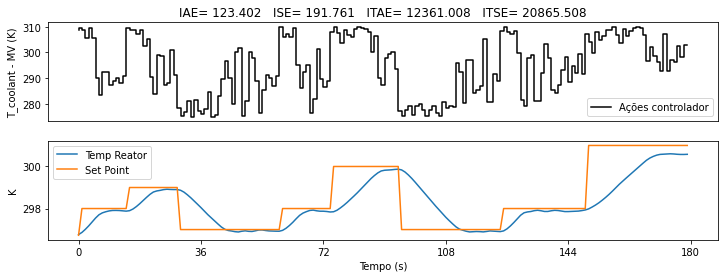

In [61]:

#Plotagem
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.title("IAE= "+'%.3f'%IAE+ "   ISE= "+'%.3f'%ISE+"   ITAE= "+'%.3f'%ITAE+"   ITSE= "+'%.3f'%ITSE)
plt.step(np.linspace(0,final_step-1,final_step),Tvc_,'k',label='Ações controlador')
plt.ylabel('T_coolant - MV (K)')
#plt.xlabel('Tempo (s)')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.legend()


#plt.figure(figsize=(12,4))
plt.subplot(2,1,2)
plt.plot(p_[1],label='Temp Reator')
plt.plot(sp_,label='Set Point')
plt.ylabel('K')
plt.xlabel('Tempo (s)')

plt.xticks(np.linspace(0,final_step,6))
plt.legend()

plt.show()



In [77]:
np.max(sp_)

301.0

In [89]:
t_ = p_.index.values

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(2,1,1)
line1, = ax1.plot([],[],c='r',marker=',',label="Reactor Temperature")
line2, = ax1.plot([],[],c='b',marker=',',label="Set-point")
ax1.set_ylim(np.min(sp_)-.5,np.max(sp_)+.5)
ax1.set_xlim(0,final_step)
ax1.legend()
ax1.set_ylabel("Temperature [K]")
ax1.set_xticks([])

ax2 = plt.subplot(2,1,2)
line3, = ax2.step([],[],c='k',marker=',',label="Controller actions")
ax2.set_ylim(np.min(Tvc_)-.5,np.max(Tvc_)+.5)
ax2.set_xlim(0,final_step)
ax2.legend()
ax2.set_ylabel("Temperature [K]")
ax2.set_xlabel("Time(s)")
ax2.set_xticks([])

plt.close()

x_data_1=[]
y_data_1=[]

x_data_2=[]
y_data_2=[]

x_data_3=[]
y_data_3=[]


def animate(i):
  global p_,sp_,Tvc_,t_
  x_data_1.append(t_[i])
  y_data_1.append(p_[1][i])

  x_data_2.append(t_[i])
  y_data_2.append(sp_[i])
  
  x_data_3.append(t_[i])
  y_data_3.append(Tvc_[i])

  line1.set_xdata(x_data_1)
  line1.set_ydata(y_data_1)
  line2.set_xdata(x_data_2)
  line2.set_ydata(y_data_2)
  line3.set_xdata(x_data_3)
  line3.set_ydata(y_data_3)

  fig.suptitle("Reactor profile at t = {:.0f}s".format(t_[i]),fontsize=15)


In [90]:
anim = FuncAnimation(fig,animate,frames=np.arange(0,final_step,1),interval=70)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

2021-05-31 19:14:34,632 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-05-31 19:14:34,640 - matplotlib.animation - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 864x288 -pix_fmt rgba -r 14.285714285714286 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkjzga0bp/temp.m4v
